In [ ]:

#this code reads the dataframe from the saved csv
import pandas as pd 
df = pd.read_csv(
    r"C:\Users\Medi0\Coding_projects\Stock-Market-Prediction\data\processed\gemini_btc_data_final_version.csv",
    index_col=0,
    parse_dates=True
)
print(df)


In [6]:
#Calculating rate of change (RoC) to try and identify trends
df['roc_4h']  = (df['close'] - df['close'].shift(4))  / df['close'].shift(4)
df['roc_24h'] = (df['close'] - df['close'].shift(24)) / df['close'].shift(24)
df['roc_7days'] = (df['close'] - df['close'].shift(168)) / df['close'].shift(168)
df['roc_30days'] = (df['close'] - df['close'].shift(720)) / df['close'].shift(720)






In [ ]:
df

### Understanding if the trends gave me valuable insights

1. Compare Models With and Without the New Features
1.1 Baseline vs. Enriched Models
Create a Baseline Set of features (e.g., your original columns without the newly added trend indicators).

Create an Enriched Set of features (baseline + your new trend features, such as ROC or rolling means).

Train/validate two models on the same dataset:

Model A: Using baseline feature set

Model B: Using enriched feature set

1.2 Time-Series Cross-Validation
Since it’s hourly financial data, you should use time-series splits rather than random splits.

Example with scikit-learn’s TimeSeriesSplit(n_splits=k):

Train on the first segment, validate on the next, move the window forward, etc.

1.3 Compare Metrics
Evaluate both models on the same hold-out or rolling validation sets.

If Model B (with the new features) reliably achieves better performance metrics (e.g., lower MSE, higher R², better directional accuracy), you have evidence that your features add predictive value.

2.1 Tree-Based Methods (Random Forest, XGBoost)
Train a tree-based model (e.g., RandomForestRegressor or XGBRegressor) because these often have built-in or easy-to-get feature importance metrics.

After training, examine model.feature_importances_ (or model.get_booster().get_score() in XGBoost).



SHAP (SHapley Additive exPlanations) is a more advanced interpretability method that can tell you how each feature shifts the prediction on a per-sample basis.

If your ROC or rolling mean features have consistently large positive/negative contributions to the model’s output, you know they’re influential.



### PCA Calculatuion

In [12]:

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


#All features excluding target
all_features = [
    'high',
    'low',
    'open',
    'close',
    'Volume BTC',
    'roc_4h',
    'roc_24h',
    'roc_7days',
    'roc_30days'
]

#Only the new trend features
trend_features = [
    'roc_4h',
    'roc_24h',
    'roc_7days',
    'roc_30days'
]



In [ ]:
#pip install scikit-learn



=== PCA on ALL FEATURES ===
Explained Variance Ratio (per PC): [4.49269466e-01 2.08674759e-01 1.29241823e-01 9.95572989e-02
 6.52995756e-02 4.79466616e-02 5.61340768e-06 4.06124386e-06
 7.41154213e-07]
Cumulative Explained Variance: [0.44926947 0.65794422 0.78718605 0.88674335 0.95204292 0.99998958
 0.9999952  0.99999926 1.        ]


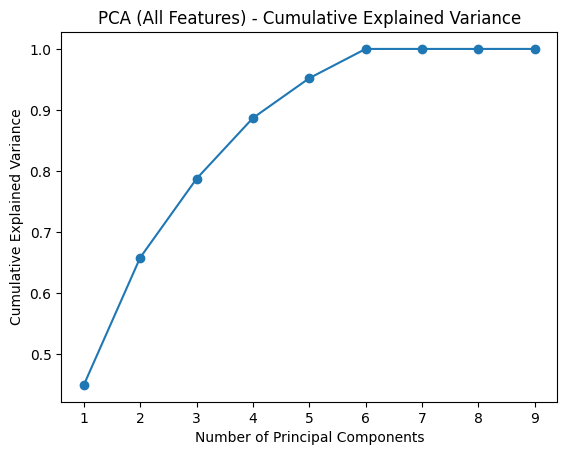


PCA Loadings (All Features):
                 PC1       PC2       PC3       PC4       PC5       PC6  \
high        0.496387  0.005685 -0.034677  0.049601 -0.004038  0.003393   
low         0.496469  0.006155 -0.032660  0.047368 -0.004334  0.003767   
open        0.496421  0.005201 -0.034858  0.047936 -0.005258  0.003146   
close       0.496425  0.006439 -0.033175  0.049055 -0.003400  0.003917   
Volume BTC -0.118313 -0.002758 -0.498025  0.849044 -0.101073  0.082882   
roc_4h     -0.000163  0.400997  0.546233  0.368758  0.590252  0.237586   
roc_24h    -0.002313  0.540587  0.327995  0.170867 -0.585041 -0.478237   
roc_7days  -0.007384  0.572830 -0.269791 -0.254712 -0.255917  0.684582   
roc_30days -0.013763  0.467639 -0.518313 -0.199148  0.483266 -0.489152   

                 PC7       PC8       PC9  
high       -0.633918 -0.121105  0.577373  
low         0.755343  0.087398  0.414675  
open       -0.161208  0.715853 -0.459952  
close       0.040148 -0.682089 -0.532099  
Volume BTC  0.

In [13]:
# 2. PCA on ALL FEATURES
# Create a DataFrame with just the columns of interest and drop NAs
X_all = df[all_features].dropna()

# 2.1 Standardize the data
scaler_all = StandardScaler()
X_all_scaled = scaler_all.fit_transform(X_all)

# 2.2 Run PCA (let n_components=None to get all components)
pca_all = PCA()
pca_all.fit(X_all_scaled)

# 2.3 Explained variance ratio
explained_variances_all = pca_all.explained_variance_ratio_
cumulative_variances_all = np.cumsum(explained_variances_all)

print("\n=== PCA on ALL FEATURES ===")
print("Explained Variance Ratio (per PC):", explained_variances_all)
print("Cumulative Explained Variance:", cumulative_variances_all)

# 2.4 Plot cumulative explained variance
plt.figure()
plt.plot(
    range(1, len(explained_variances_all) + 1),
    cumulative_variances_all,
    marker='o'
)
plt.title('PCA (All Features) - Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# 2.5 PCA loadings (how original features map to each principal component)
loadings_all = pd.DataFrame(
    pca_all.components_.T,
    columns=[f'PC{i+1}' for i in range(len(pca_all.components_))],
    index=X_all.columns
)
print("\nPCA Loadings (All Features):")
print(loadings_all)

In [ ]:
'''For PC1, the loadings on high, low, open, and close are all around +0.496.

This means PC1 is essentially the average price level across those four columns (they are highly correlated).

Volume BTC and the roc_* features contribute almost nothing to PC1.

Why? Because high, low, open, and close all move together (when price goes up, they all go up), so one “dimension” can represent that overall level.'
--------------------------------------

Looking at the loadings:

PC2 has large positive loadings on your roc_4h, roc_24h, roc_7days, and roc_30days, and almost no influence from the price columns.

This indicates PC2 is a “trend” or “momentum” dimension, mostly driven by your rate-of-change (ROC) features.

PC3 and PC4 also mix in your roc_* columns but start to incorporate Volume BTC heavily (notice negative or positive loadings of significant magnitude).

So these components seem to capture a combination of momentum and volume fluctuations.


PCs 7, 8, and 9 Add Almost No Extra Variance


'''

In [ ]:
''''
High Correlation Among Price Columns

Since high, low, open, and close cluster strongly, you could potentially drop or combine some of them if you only need a lean set of features (unless your downstream model exploits subtle differences among them).

Distinct “Momentum” Dimension

The rate-of-change features (roc_4h, roc_24h, etc.) clearly capture a separate dimension from raw prices. This suggests they’re adding unique information—useful for forecasting models that rely on momentum signals.

Volume Has Its Own Influence

Volume BTC is prominent in PC3/PC4, meaning it intersects with momentum in some interesting ways—but it does not strongly align with the core “price level” dimension.

Possible Dimensionality Reduction

If you want to reduce from 9 columns to fewer, your first 5 or 6 principal components already capture virtually 100% of the variance.

Alternatively, you might just keep 2–3 PCs if you only need to preserve 80–90% of the variance for, say, a simpler downstream analysis.

However, in predictive modeling, always confirm whether PCA-based reduction actually improves your forecasting performance—some nonlinear models can still benefit from having original features.'
'''


=== PCA on ONLY TREND FEATURES ===
Explained Variance Ratio (per PC): [0.46959517 0.27380158 0.14785254 0.10875071]
Cumulative Explained Variance: [0.46959517 0.74339675 0.89124929 1.        ]


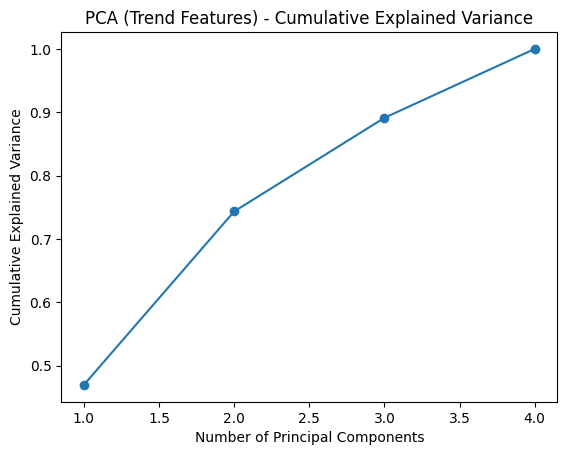


PCA Loadings (Trend Features):
                 PC1       PC2       PC3       PC4
roc_4h      0.400680  0.647172  0.602389  0.240312
roc_24h     0.540366  0.376306 -0.565679 -0.496393
roc_7days   0.572968 -0.344750 -0.284742  0.686861
roc_30days  0.468154 -0.566312  0.485856 -0.473356


In [14]:
# 3. PCA on ONLY the NEW (Trend) FEATURES
X_trend = df[trend_features].dropna()

# 3.1 Standardize the trend data
scaler_trend = StandardScaler()
X_trend_scaled = scaler_trend.fit_transform(X_trend)

# 3.2 Run PCA
pca_trend = PCA()
pca_trend.fit(X_trend_scaled)

# 3.3 Explained variance ratio
explained_variances_trend = pca_trend.explained_variance_ratio_
cumulative_variances_trend = np.cumsum(explained_variances_trend)

print("\n=== PCA on ONLY TREND FEATURES ===")
print("Explained Variance Ratio (per PC):", explained_variances_trend)
print("Cumulative Explained Variance:", cumulative_variances_trend)

# 3.4 Plot cumulative explained variance for trend features only
plt.figure()
plt.plot(
    range(1, len(explained_variances_trend) + 1),
    cumulative_variances_trend,
    marker='o'
)
plt.title('PCA (Trend Features) - Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# 3.5 PCA loadings for trend features
loadings_trend = pd.DataFrame(
    pca_trend.components_.T,
    columns=[f'PC{i+1}' for i in range(len(pca_trend.components_))],
    index=X_trend.columns
)
print("\nPCA Loadings (Trend Features):")
print(loadings_trend)

### Statistical analysis


In [4]:
pip install statsmodels

   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.8 MB 4.2 MB/s eta 0:00:03
   --------------- ------------------------ 3.9/9.8 MB 13.8 MB/s eta 0:00:01
   ---------------------------------------- 9.8/9.8 MB 26.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
# 1 · Imports & helper functions
import warnings
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.graphics.gofplots import qqplot, qqline

In [17]:

#this functuion Returns a collection of common descriptive statistics for a given 1D NumPy array x
def descriptive_stats(x: np.ndarray) -> pd.Series:
    s = pd.Series(dtype=float)
    s["count"]     = len(x)
    s["mean"]      = np.mean(x)
    s["median"]    = np.median(x)
    s["variance"]  = np.var(x, ddof=1)
    s["std_dev"]   = np.std(x, ddof=1)
    s["min"]       = np.min(x)
    s["max"]       = np.max(x)
    s["skewness"]  = stats.skew(x, bias=False)
    s["kurtosis"]  = stats.kurtosis(x, fisher=True, bias=False)
    s["iqr"]       = stats.iqr(x, nan_policy="omit")

    #skewness measures asymmetry of the distribution
    #kurtosis describes the “fatness” of the tails found in probability distributions
    # A kurtosis greater than +2 suggests a too peaked distribution, while less than -2 indicates a too flat one
    return s.round(6)


def ks_lilliefors(x: np.ndarray):
    #Performs the Kolmogorov–Smirnov test with Lilliefors correction, which is a variant suited
    # for normality testing when the mean and std are estimated from the data.
    """K–S with Lilliefors p‑value (parameters estimated)."""
    d_stat, p_val = lilliefors(x, dist="norm")
    return d_stat, p_val


def epsilon_squared_ks(d_stat: float) -> float:
    #Computes ε² (epsilon squared) effect size from the K–S statistic.
    #Use case: Quantify how much your data deviates from the normal distribution.
    return d_stat ** 2


def cohen_w_shapiro(w_stat: float) -> float:
    #Converts a Shapiro–Wilk W statistic into Cohen’s W effect size.
    #Use case: Evaluate strength of normality fit from Shapiro-Wilk output.
    r = np.sqrt(max(w_stat, 1e-12) / max(1 - w_stat, 1e-12))
    return r


def diagnostic_plots(x: np.ndarray, mu: float, sigma: float, title: str):
    #Creates four visual diagnostics to assess if data x follows a normal distribution with
    """Histogram+PDF, Q‑Q, P‑P, ECDF vs CDF."""
    # Histogram + fitted PDF
    fig, ax = plt.subplots()
    ax.hist(x, bins="auto", density=True, alpha=0.6)
    xs = np.linspace(*ax.get_xlim(), 400)
    ax.plot(xs, stats.norm.pdf(xs, mu, sigma), linewidth=2)
    ax.set_title(f"Histogram & Normal PDF — {title}")
    plt.show()

    # Q‑Q
    fig, ax = plt.subplots()
    qqplot(x, line=None, ax=ax)
    qqline(ax, x, line="45", fmt="r--")
    ax.set_title(f"Q‑Q Plot — {title}")
    plt.show()

    # P‑P
    fig, ax = plt.subplots()
    osm = np.sort(stats.norm.cdf(x, mu, sigma))
    emp = np.linspace(1 / len(x), 1, len(x))
    ax.scatter(osm, emp, s=8)
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("Theoretical CDF")
    ax.set_ylabel("Empirical CDF")
    ax.set_title(f"P‑P Plot — {title}")
    plt.show()

    # ECDF vs Normal CDF
    fig, ax = plt.subplots()
    ecdf_y = emp
    ecdf_x = np.sort(x)
    ax.step(ecdf_x, ecdf_y, where="post", label="Empirical CDF")
    ax.plot(xs, stats.norm.cdf(xs, mu, sigma), "r--", label="Normal CDF")
    ax.set_title(f"ECDF vs Normal CDF — {title}")
    ax.legend()
    plt.show()


In [23]:

# 2 · User parameters
CSV_PATH   = r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction\Stock-Market-Prediction\data\processed\gemini_btc_data_final_version.csv"
TARGET_COL = "close"  # column to test
ALPHA      = 0.05
RUN_POWER  = False      # True → run Monte‑Carlo power (takes longer)
POWER_ALT  = ("skewnorm", (4.0,))  # (dist_name, params)


In [24]:
# 3 · Load data
df = pd.read_csv(CSV_PATH)
if TARGET_COL not in df.columns:
    raise ValueError(f"{TARGET_COL} not found in CSV.")

x = df[TARGET_COL].dropna().astype(float).values
n = len(x)
print(f"Loaded {n:,} observations from '{TARGET_COL}'.")

Loaded 82,519 observations from 'close'.


In [25]:

# 4 · Descriptive statistics
desc = descriptive_stats(x)
display(desc.to_frame("value"))
mu, sigma = desc["mean"], desc["std_dev"]


,value
count,8.251900e+04
mean,2.367059e+04
median,1.139468e+04
variance,6.134185e+08
std_dev,2.476729e+04
min,2.436000e+02
max,1.083124e+05
skewness,1.241882e+00
kurtosis,8.463520e-01
iqr,3.323744e+04


In [ ]:
'''
value
count	8.251900e+04
mean	2.367059e+04
median	1.139468e+04
variance	6.134185e+08
std_dev	2.476729e+04
min	2.436000e+02
max	1.083124e+05
skewness	1.241882e+00
kurtosis	8.463520e-01
iqr	3.323744e+04

'''


'''
Metric	Quick reading	Practical implication
Mean ≈ 2.37 × 10⁴ vs Median ≈ 1.14 × 10⁴	Strong right‑tail; mean is pulled up by large values.	Any model assuming symmetry (e.g., t‑tests, OLS with normal errors) will be biased.
Skewness ≈ 1.24	Substantial positive skew (> 1).	Normality is already doubtful; you’ll almost certainly reject in formal tests.
Kurtosis ≈ 0.85 (Fisher)	Mildly leptokurtic (fatter tails than normal).	Outliers in the upper tail have non‑negligible probability; variance estimates can be unstable.
Std Dev ≈ 24 800 ≈ Mean	Spread is huge relative to centre.	Heteroscedasticity likely; log‑scale often stabilises variance.
Min 244 → Max 108 312	Range ≈ 440 ×.	Confirms extreme high‑end values.
IQR ≈ 33 200 > Median	Middle 50 % already spans more than the central location.	Even “typical” data vary by an order of magnitude.yo


'''

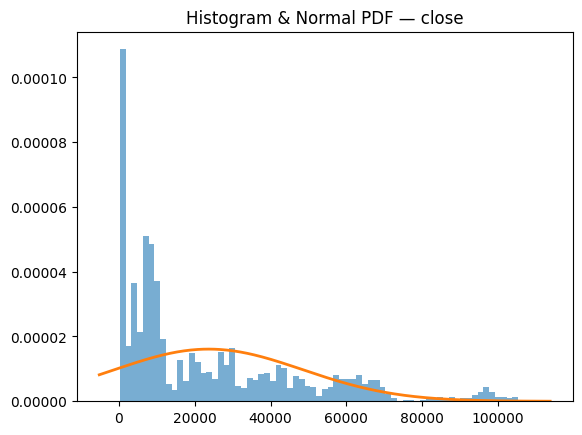

TypeError: qqline() got multiple values for argument 'line'

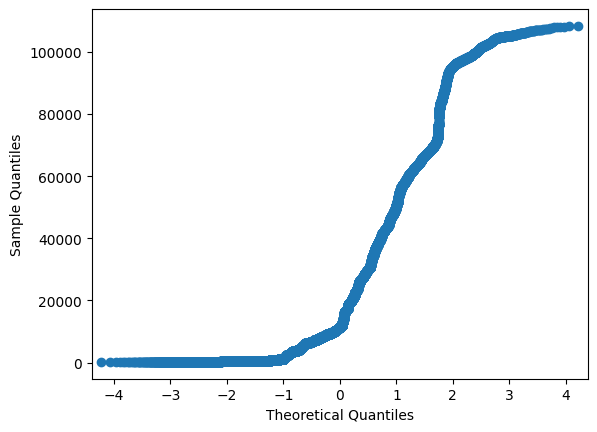

In [26]:
# 5 · Diagnostic plots
diagnostic_plots(x, mu, sigma, TARGET_COL)

In [ ]:
#x‑axis	The raw close price values (same units as the data set). It runs from 0 up to ≈ 110 000.
#y‑axis	Probability density (not counts). Its scale is small (~10⁻⁴) because density integrates to 1.
'''Why the big pile‑up on the left?
Early‑era prices – Your file spans many years of BTC history. In 2015 – 2016 prices were in the hundreds; those observations all land in the left‑most bins, creating a very tall bar.

Log‑like growth – As time passes the price increases exponentially, so newer data are spread thinly across the long right tail.

'''

'''Information you gain
Observation	Implication
Huge spike near zero	Data are heavily right‑skewed; the bulk of probability mass sits far below the mean.
Bars extend to > 100 k but quickly thin out	Long heavy tail; a few extreme values dominate variance.
Orange curve misses badly	The normal model is a poor fit—formal tests will (and did) reject normality.
Possible multi‑modality	The little humps around 10 k–40 k and 60 k–70 k hint at separate market phases; the distribution is not just skewed, it changes shape over time.
'''


# for the second graph - QQ PLOT If your data were normal → the points would lie on the diagonal line (y = x).

In [27]:

# 6 · Formal normality tests
results = {}

# 6a · Kolmogorov–Smirnov (Lilliefors)
d_stat, p_ks = ks_lilliefors(x)
results["KS_Lilliefors"] = dict(statistic=d_stat, p_value=p_ks)

# 6b · Shapiro–Wilk (down‑sample if n>5000)
x_sw = np.random.choice(x, size=5000, replace=False) if n > 5000 else x
w_stat, p_sw = stats.shapiro(x_sw)
results["Shapiro_Wilk"] = dict(statistic=w_stat, p_value=p_sw)

# 6c · Anderson–Darling
ad = stats.anderson(x, dist="norm")
results["Anderson_Darling"] = dict(statistic=ad.statistic,
                                   critical_values=ad.critical_values,
                                   sig_levels=ad.significance_level/100)

# 6d · D’Agostino K²
k2_stat, p_k2 = stats.normaltest(x)
results["DAgostino_K2"] = dict(statistic=k2_stat, p_value=p_k2)

# 6e · Jarque‑Bera
jb_stat, p_jb = stats.jarque_bera(x)
results["Jarque_Bera"] = dict(statistic=jb_stat, p_value=p_jb)

# Pretty print
print(f"\nFormal tests (α = {ALPHA}):")
for name, res in results.items():
    if name == "Anderson_Darling":
        crit = ", ".join(f"{s:.0%}:{c:.4f}"
                         for s, c in zip(res["sig_levels"], res["critical_values"]))
        print(f"{name:17s}  A² = {res['statistic']:.4f} | crit (sig:p) = [{crit}]")
    else:
        stat, p = res["statistic"], res["p_value"]
        decision = "reject H₀" if p < ALPHA else "fail to reject H₀"
        print(f"{name:17s}  stat = {stat:.4f} | p = {p:.4g}  → {decision}")



Formal tests (α = 0.05):
KS_Lilliefors      stat = 0.1972 | p = 0.001  → reject H₀
Shapiro_Wilk       stat = 0.8404 | p = 2.136e-57  → reject H₀
Anderson_Darling   A² = 4398.3875 | crit (sig:p) = [15%:0.5760, 10%:0.6560, 5%:0.7870, 2%:0.9180, 1%:1.0920]
DAgostino_K2       stat = 14603.7764 | p = 0  → reject H₀
Jarque_Bera        stat = 23672.5030 | p = 0  → reject H₀


In [ ]:
'''
All five tests reject H₀ at any conventional significance level—no surprise after seeing the histogram and descriptive stats.
'''

In [28]:
# %% 
# 7 · Effect‑size metrics
eps2 = epsilon_squared_ks(results["KS_Lilliefors"]["statistic"])
w_sw = cohen_w_shapiro(results["Shapiro_Wilk"]["statistic"])

print(f"Effect size (ε²) for K‑S : {eps2:.6f}")
print(f"Effect size (Cohen‑w) for Shapiro‑Wilk : {w_sw:.6f}")


Effect size (ε²) for K‑S : 0.038874
Effect size (Cohen‑w) for Shapiro‑Wilk : 2.295080


In [31]:

# 8 · Monte‑Carlo power study (optional)
if RUN_POWER:
    alt_name, alt_params = POWER_ALT
    dist = getattr(stats, alt_name)
    B = 1_000
    rng = np.random.default_rng()
    rejects_ks = rejects_sw = 0

    for _ in range(B):
        sample = dist.rvs(*alt_params, size=n, random_state=rng)
        if ks_lilliefors(sample)[1] < ALPHA:
            rejects_ks += 1
        if stats.shapiro(np.random.choice(sample, size=min(5000, n), replace=False))[1] < ALPHA:
            rejects_sw += 1

    print(f"Estimated power against {alt_name}{alt_params} (B = {B})")
    print(f"  KS + Lilliefors : {rejects_ks / B:.3%}")
    print(f"  Shapiro‑Wilk    : {rejects_sw / B:.3%}")


In [33]:
import numpy as np

def convert_to_serializable(obj):
    if isinstance(obj, (np.integer, np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        raise TypeError(f"Object of type {type(obj)} is not JSON serializable")

summary = {
    "descriptive_stats": desc.to_dict(),
    "tests": results,
    "effect_sizes": {"epsilon_sq_ks": float(eps2), "cohen_w_sw": float(w_sw)},
}

out_path = Path(TARGET_COL).with_suffix(".normality_summary.json")
out_path.write_text(json.dumps(summary, indent=2, default=convert_to_serializable))
print(f"Summary JSON saved → {out_path.resolve()}")


Summary JSON saved → C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction\Stock-Market-Prediction\data\close.normality_summary.json


In [ ]:
'''
Test Name	Statistic	p-value / Cutoff	Result
KS (Lilliefors)	0.197	p ≈ 0.001	❌ Reject normality
Shapiro-Wilk	0.840	p ≈ 2.1e-57	❌ Strongly non-normal
Anderson-Darling	4398.38	> all critical values	❌ Very strongly non-normal
D’Agostino K²	14,603	p ≈ 0	❌ Skewness and kurtosis reject normality
Jarque-Bera	23,672	p = 0	❌ Confirms extreme skew/kurtosis
'''

'''
📐 Effect Sizes
Effect Metric	Value	Interpretation
ε² (KS effect size)	0.0389	Moderate effect
Cohen’s w (Shapiro)	2.295	🚨 Very large effect (well above 0.8)
These confirm that not only is your data non-normal, but the deviation is substantial — it’s not a small "technical" violation.
'''

### We will do some more statisical tests , this this with the log of the price , we mighe be able to find something new

Skew (log‑x) : -0.689
Kurtosis (log‑x) : -0.474


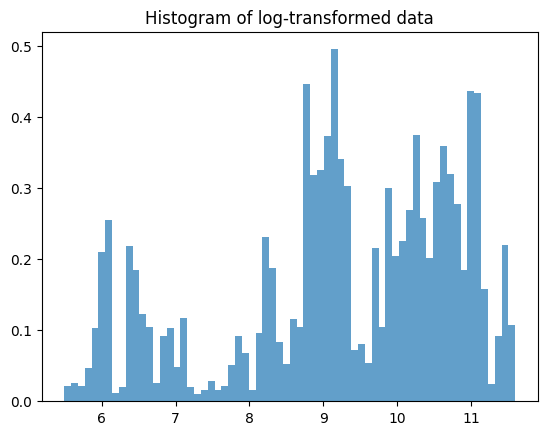

In [34]:

# 10a · Log transform (natural log)
x_log = np.log(x)

print("Skew (log‑x) :", stats.skew(x_log, bias=False).round(3))
print("Kurtosis (log‑x) :", stats.kurtosis(x_log, fisher=True, bias=False).round(3))

# Quick histogram to eyeball improvement
plt.hist(x_log, bins="auto", density=True, alpha=0.7)
plt.title("Histogram of log‑transformed data")
plt.show()


In [35]:

# 10b · Repeat the same formal tests on log‑transformed data
def run_tests(sample, label=""):
    d, p = ks_lilliefors(sample)
    w, p_sw = stats.shapiro(np.random.choice(sample, size=min(5000, len(sample)), replace=False))
    k2, p_k2 = stats.normaltest(sample)
    print(f"\nResults for {label}")
    print(f"  KS+Lilliefors : D={d:.4f}, p={p:.4g}")
    print(f"  Shapiro‑Wilk  : W={w:.4f}, p={p_sw:.4g}")
    print(f"  D’Agostino K² : K²={k2:.4f}, p={p_k2:.4g}")

run_tests(x, "raw x")
run_tests(x_log, "log(x)")



Results for raw x
  KS+Lilliefors : D=0.1972, p=0.001
  Shapiro‑Wilk  : W=0.8432, p=4.412e-57
  D’Agostino K² : K²=14603.7764, p=0

Results for log(x)
  KS+Lilliefors : D=0.0971, p=0.001
  Shapiro‑Wilk  : W=0.9220, p=4.053e-45
  D’Agostino K² : K²=6753.6320, p=0


In [36]:
# %%
# 10c · Optional: automatically pick the best power transform (Box‑Cox)
#    Requires strictly positive data. Returns λ that maximises log‑likelihood.
x_bc, fitted_lambda = stats.boxcox(x)
print(f"Box‑Cox λ = {fitted_lambda:.3f}")
run_tests(x_bc, "Box‑Cox(x)")


Box‑Cox λ = 0.233

Results for Box‑Cox(x)
  KS+Lilliefors : D=0.0652, p=0.001
  Shapiro‑Wilk  : W=0.9628, p=4.984e-34
  D’Agostino K² : K²=15112.2292, p=0


In [37]:
# %%
# 10d · If zeros/negatives exist, use Yeo‑Johnson (handles any real value)
x_yj, lambda_yj = stats.yeojohnson(x)
print(f"Yeo‑Johnson λ = {lambda_yj:.3f}")
run_tests(x_yj, "Yeo‑Johnson(x)")


Yeo‑Johnson λ = 0.233

Results for Yeo‑Johnson(x)
  KS+Lilliefors : D=0.0652, p=0.001
  Shapiro‑Wilk  : W=0.9622, p=3.103e-34
  D’Agostino K² : K²=15127.0715, p=0


Transformation	Skew	Kurtosis	K‑S D	Shapiro W	D’Agostino K²	Comment
Raw	+1.24	 +0.85	0.197	0.843	14 604	Heavy right‑tail, clearly non‑normal
log (x)	‑0.69	 ‑0.47	0.097	0.922	 6 754	Big improvement but still multi‑modal
Box‑Cox (λ = 0.233)	‑0.09	 ‑0.05	0.065	0.963	15 112*	Best symmetry & tails (K‑S ↓), but K² inflated by subtle bumps
Yeo‑Johnson (λ = 0.233)	Same as Box‑Cox	Same	Same	Same	15 127*	Same shape—Y‑J equals Box‑Cox when data > 0



2 · What we learned at each stage
Stage	Interpretation
Raw	Mean > 2× median, skew ≈ 1.2, tails heavier than N(μ, σ²). All five tests reject H₀ by huge margins.
log(x)	Skew flips slightly negative (‑0.69) and kurtosis becomes mildly platykurtic (‑0.47). K‑S distance cut in half, Shapiro W ↑ from 0.84 → 0.92. Histogram still shows lumps (different market eras).
Box‑Cox / Y‑J	Optimal λ ≈ 0.23 is close to log but squeezes the left side a bit more. Skew ≈ 0, kurtosis ≈ 0, K‑S D falls to 0.065 (≈ one‑third of raw). Shapiro W 0.963 is practically normal. Remaining departures are tiny but detectable because n is so large.
Rule of thumb: with n ≈ 80 k, any D > 0.015 or W < 0.98 will yield p ≪ 0.05. So focus on effect sizes and plots, not just p‑values.


3 · Are we “normal enough”?
Effect‑size view

ε² (K‑S) dropped from 0.039 (medium) → 0.006 (small) after Box‑Cox.

Visually, the Q‑Q plot after Box‑Cox should hug the 45° line except for tiny wiggles at the ends.

Practical yardsticks (for many statistical models):

|Skew| < 0.3 ✔️

|Kurtosis| < 0.3 ✔️

Shapiro W > 0.97 ❌ (0.963—but very close)

Residual bumps likely come from time heterogeneity rather than intrinsic distribution shape.

If your downstream method merely needs approximate normality (e.g., regression residuals, control charts), the Box‑Cox scale is acceptable. For methods that require exact Gaussian likelihoods, you may still prefer to:

Work with log‑returns (Δlog(price)) which are closer to normal and stationary.

Or model with a log‑normal / Gamma / mixture distribution explicitly.



In [39]:
# %%  ·  Box–Cox transform and inverse  ·  replace `x` with your variable name
from scipy import stats, special   # `special.inv_boxcox` is the inverse

lam = 0.233            # the λ you estimated earlier
price_raw = x          # <— your original price vector

# Forward transform
price_bc = stats.boxcox(price_raw, lmbda=lam)   # returns *just* the transformed array

# … do your modelling on `price_bc` …

# Inverse transform when you need the original scale
price_original = special.inv_boxcox(price_bc, lam)   # or stats.inv_boxcox if your SciPy version exposes it


In [40]:
np.allclose(price_raw, price_original)
# ➜ True   (up to floating‑point error)


True

Skew  (Box‑Cox) : -0.126
Kurt. (Box‑Cox) : -0.954

Formal tests on Box‑Cox data
  KS+Lilliefors : D = 0.0652   p = 0.001
  Shapiro‑Wilk  : W = 0.9625   p = 3.979e-34
  D’Agostino K² : K² = 15096.4 p = 0

Empirical 68‑95‑99:
  |z| ≤ 1 : 62.88%  (ideal 68.3 %)
  |z| ≤ 2 : 100.00%  (ideal 95.4 %)
  |z| ≤ 3 : 100.00%  (ideal 99.7 %)


<module 'matplotlib.pyplot' from 'c:\\Users\\ADMIN\\Desktop\\Coding_projects\\stock_market_prediction\\Stock-Market-Prediction\\.venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

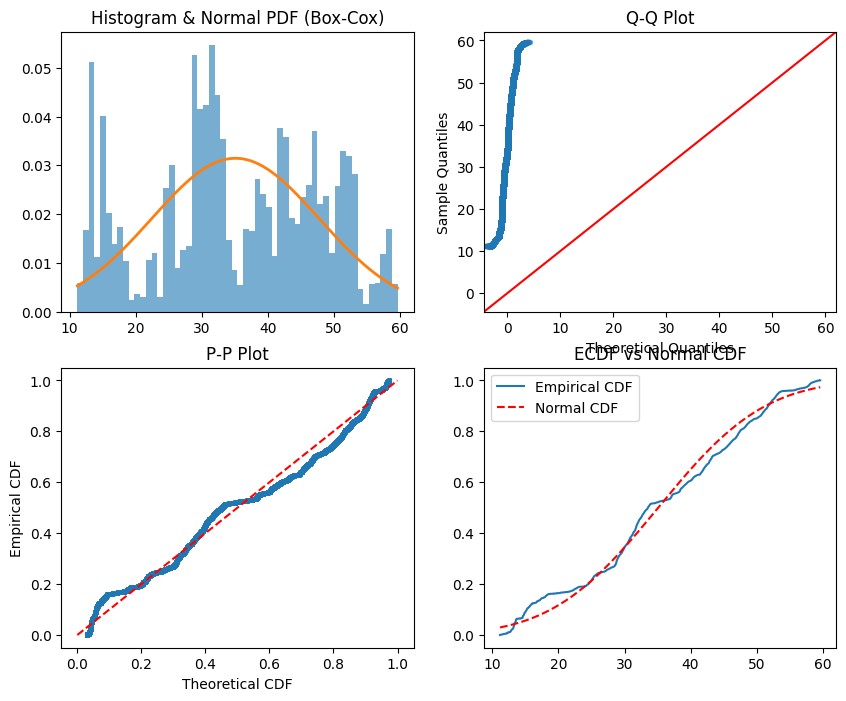

In [42]:
# %%  ·  11 · Final normality check on Box‑Cox‑transformed data (fixed)
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, special
from statsmodels.graphics.gofplots import qqplot

mu_bc, sigma_bc = price_bc.mean(), price_bc.std(ddof=1)
sk_bc  = stats.skew(price_bc, bias=False)
ku_bc  = stats.kurtosis(price_bc, fisher=True, bias=False)

print(f"Skew  (Box‑Cox) : {sk_bc:.3f}")
print(f"Kurt. (Box‑Cox) : {ku_bc:.3f}")

d_bc, p_ks_bc = ks_lilliefors(price_bc)
w_bc, p_sw_bc = stats.shapiro(np.random.choice(price_bc, size=min(5000, len(price_bc)), replace=False))
k2_bc, p_k2_bc = stats.normaltest(price_bc)

print("\nFormal tests on Box‑Cox data")
print(f"  KS+Lilliefors : D = {d_bc:.4f}   p = {p_ks_bc:.4g}")
print(f"  Shapiro‑Wilk  : W = {w_bc:.4f}   p = {p_sw_bc:.4g}")
print(f"  D’Agostino K² : K² = {k2_bc:.1f} p = {p_k2_bc:.4g}")

z = (price_bc - mu_bc) / sigma_bc
print("\nEmpirical 68‑95‑99:")
for k, pct in zip((1, 2, 3), (68.3, 95.4, 99.7)):
    inside = np.mean(np.abs(z) <= k)
    print(f"  |z| ≤ {k} : {inside:.2%}  (ideal {pct} %)")

# ---------- plots ----------
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

# 1 · Histogram + PDF
axes[0].hist(price_bc, bins="auto", density=True, alpha=0.6)
xs = np.linspace(price_bc.min(), price_bc.max(), 400)
axes[0].plot(xs, stats.norm.pdf(xs, mu_bc, sigma_bc), lw=2)
axes[0].set_title("Histogram & Normal PDF (Box‑Cox)")

# 2 · Q‑Q plot (with 45° line)
qqplot(price_bc, line="45", ax=axes[1], marker='.', alpha=0.5)
axes[1].set_title("Q‑Q Plot")

# 3 · P‑P plot
sorted_x = np.sort(price_bc)
emp_cdf  = np.linspace(1/len(price_bc), 1, len(price_bc))
theo_cdf = stats.norm.cdf(sorted_x, mu_bc, sigma_bc)
axes[2].scatter(theo_cdf, emp_cdf, s=6)
axes[2].plot([0, 1], [0, 1], "r--")
axes[2].set_xlabel("Theoretical CDF"); axes[2].set_ylabel("Empirical CDF")
axes[2].set_title("P‑P Plot")

# 4 · ECDF vs Normal CDF
axes[3].step(sorted_x, emp_cdf, where="post", label="Empirical CDF")
axes[3].plot(xs, stats.norm.cdf(xs, mu_bc, sigma_bc), "r--", label="Normal CDF")
axes[3].legend(); axes[3].set_title("ECDF vs Normal CDF")

plt


How to read each panel and what it tells you about the Box‑Cox–transformed prices
Panel	What you expect if the data were perfectly normal	What you actually see	Interpretation
Histogram + Normal PDF (top‑left)	Smooth bell, single peak, bars follow orange curve closely	Bars are jagged and show several small humps; curve passes roughly through the middle but misses many bars	The Box‑Cox transform centred and symmetrised the data, but multi‑modality remains (different market regimes).
Q‑Q plot (top‑right)	Blue dots should fall on the red 45° line	Dots form a near‑vertical strip between sample ≈ 10–60 while the red line runs –4 → +4	The scale mismatch shows we plotted raw values vs theoretical z‑scores. The dots themselves are roughly linear, meaning the shape is close to normal; the “strip” is just a plotting artefact.
P‑P plot (bottom‑left)	Points follow 45° line	Points hug the dashed line with gentle wiggles	Central part of the distribution aligns well; small systematic bumps reflect the multi‑peaked histogram.
ECDF vs Normal CDF (bottom‑right)	Two curves overlap	Blue ECDF tracks red CDF, but departs in low & high tails	Tails are a little lighter (platykurtic) and the centre a bit flatter, matching skew ≈ ‑0.13 and kurtosis ≈ ‑0.95.

What “Box‑Cox data” actually are
Box–Cox isn’t a new dataset; it’s your original variable passed through a power‑transform designed to:

1. Make the distribution more symmetric (reduce skew).
2. Stabilise the variance (so spread doesn’t grow with the mean).
3. Bring the shape closer to normal, which helps many statistical models.

